# Happy Indigenous People's Day

# A return to distributional semantics

Today's topics
* A brief review of Latent Semantic Analysis
* Discussion of document embeddings
* word2vec

Announcements:
* Homework 4 will be released this afternoon. Per the updated syllabus, it will be due October 29, 2021. Even if you do not start the homework yet, open it up and follow along closely with lectures to find what you need to understand.
* Homework 3 grades are still in progress. If you asked for an extension, there will be some delays in getting grades back. Expect HW3 grades by the end of the week.

In [1]:
from google.colab import drive, files
import pandas as pd

abstract_file = files.upload()

abstracts = abstract_file['abstracts.tsv'].decode("utf-8").split('\n')

Saving abstracts.tsv to abstracts.tsv


In [2]:
import nltk
nltk.download("punkt")
nltk.download('stopwords')
from nltk import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

nltk_stops = stopwords.words("english")
missing_stops = ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would']
stop_words = nltk_stops + missing_stops

vectorizer = CountVectorizer( # instantiate sparse matrix-creator
    tokenizer=word_tokenize, # with our tokenization algorithm
    stop_words=stop_words, # typically remove stop words
    lowercase=True) # optionally lowercase words
# basically just one line to get a giant matrix
bow_abstracts = vectorizer.fit_transform(abstracts)

bow_abstracts

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


<27471x74170 sparse matrix of type '<class 'numpy.int64'>'
	with 1946891 stored elements in Compressed Sparse Row format>

# Interpreting the word vector dimensions

Finally, we can try to interpret the top words for each dimension, let's just try the first 7 dimensions.

What we'll find is that some of them are interpretable, and others are less interpretable. For example, the 0th component appears to be frequent non-English words (e.g., "de", "é" from French) and symbols (\{, \}). The fourth component (=3) includes $LaTeX$ formatting symbols and other simple non-alphabetic letters. The third (=2) looks to be academic code words, and so on. 

The degree to which your space is interpretable depends on a few factors:

1. How many vocabulary terms you are using at the beginning and how sparse they are
2. How many dimensions you want to learn
3. What your learning algorithm is to generate word vectors (e.g., PCA vs. co-occurrence/mutual information vs. word2vec)

In [3]:
from sklearn.decomposition import TruncatedSVD
pca = TruncatedSVD(n_components=25)
pca.fit(bow_abstracts)
word_vectors = pca.components_.T

for dim in range(15):
  dim_vecs = word_vectors.T[dim]
  dim_vecs_named = dict(zip(vectorizer.get_feature_names(),
                            dim_vecs.tolist()))
  print(dim)
  print('\t'.join([x[0] for x in sorted(dim_vecs_named.items(), key=lambda item: item[1])[-7:]]))
  print("-" * 100)

0
'	de	.	,	\'e	{	}
----------------------------------------------------------------------------------------------------
1
models	model	language	(	)	.	,
----------------------------------------------------------------------------------------------------
2
tutorial	including	al.	e.g.	et	;	,
----------------------------------------------------------------------------------------------------
3
%	1	\	:	;	(	)
----------------------------------------------------------------------------------------------------
4
116	105	110	97	111	101	32
----------------------------------------------------------------------------------------------------
5
''	{	}	%	models	\	model
----------------------------------------------------------------------------------------------------
6
\	'	''	{	}	system	corpus
----------------------------------------------------------------------------------------------------
7
training	machine	languages	models	data	translation	language
----------------------------------------------

## Obtaining document representations with LSA

In general, latent semantic analysis (LSA) is a great place to start to explore your data. You can use LSA word vectors in a wide variety of tasks. 

But, because of the way PCA works, we can also create a _document_ representation that lives in the same size space. Basically, we do matrix multiplication between our word embeddings (`word_vectors`) and our original bag-of-words matrix (`bow_abstracts`). 

`bow_abstracts * word_vectors`

In this example, we would obtain a lower-dimensional document matrix that is 100 dimensions instead of 80,000.

In [4]:
document_embeddings = pca.transform(bow_abstracts)
print(document_embeddings)

[[ 4.13815811 11.11587934 -0.30377429 ...  0.44884097 -0.2514207
  -0.80736889]
 [ 3.21875736  8.60545633  1.73131588 ... -0.51021759 -0.06641183
   0.28601048]
 [ 3.10500404  8.4931142   0.53965843 ... -0.69344295  0.38111936
  -0.1489152 ]
 ...
 [30.48578383  1.25238543  4.7919043  ...  3.6036478   5.45698146
  -0.33974106]
 [ 7.30122149  1.31503462  1.47304996 ...  0.91350222  1.18078048
   0.15332986]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


In [5]:
print(document_embeddings.shape)

(27471, 25)


Document embeddings are a multiplication problem!

If we have a dataset with 10 documents $D$ and a vocabulary $V$ of 100,000 words, then we have a $[10 x 100000]$ matrix for our dataset. To turn 100,000 words into 100 dimensions, we need a projection matrix $P$ with dimensionality $[100000, 100]$. We then multiply $D x P$ to get a matrix of $[10 x 100]$.

In [6]:
# getting document embeddings is a multiplication problem
a = bow_abstracts * word_vectors
# test for equivalence in methods
a==document_embeddings

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [7]:
document_embeddings_df = pd.DataFrame(document_embeddings)

# Exploring the document embeddings

### Sort by each dimension to find the "top" match along that dimension.

This document scores the highest on the 0th/first dimension because it is incredibly French.

What is the most French document?

In [8]:
french_topic_id: int = 0
abstracts[document_embeddings_df.sort_values(french_topic_id, ascending=False).iloc[0].name]

"La quasi-totalit{\\'e} des {\\'e}tiqueteurs grammaticaux mettent en oeuvre des r{\\`e}gles qui portent sur les successions ou collocations permises de deux ou trois cat{\\'e}gories grammaticales. Leurs performances s{'}{\\'e}tablissent {\\`a} hauteur de 96{\\%} de mots correctement {\\'e}tiquet{\\'e}s, et {\\`a} moins de 57{\\%} de phrases correctement {\\'e}tiquet{\\'e}es. Ces r{\\`e}gles binaires et ternaires ne repr{\\'e}sentent qu{'}une fraction du total des r{\\`e}gles de succession que l{'}on peut extraire {\\`a} partir des phrases d{'}un corpus d{'}apprentissage, alors m{\\^e}me que la majeure partie des phrases (plus de 98{\\%} d{'}entre elles) ont une taille sup{\\'e}rieure {\\`a} 3 mots. Cela signifie que la plupart des phrases sont analys{\\'e}es au moyen de r{\\`e}gles reconstitu{\\'e}es ou simul{\\'e}es {\\`a} partir de r{\\`e}gles plus courtes, ternaires en l{'}occurrence dans le meilleur des cas. Nous montrons que ces r{\\`e}gles simul{\\'e}es sont majoritairement agram

In [9]:
machine_translation_id: int = 8
abstracts[document_embeddings_df.sort_values(machine_translation_id, ascending=False).iloc[0].name]

"We wrote this report in Japanese and translated it by NEC's machine translation system PIVOT/JE.) IBS (International Business Service) is the company which does the documentation service which contains translation business. We introduced a machine translation system into translation business in earnest last year. The introduction of a machine translation system changed the form of our translation work. The translation work was divided into some steps and the person who isn't experienced became able to take it of the work of each of translation steps. As a result, a total translation cost reduced. In this paper, first, we report on the usage of our machine translation system. Next, we report on translation quality and the translation cost with a machine translation system. Lastly, we report on the merit which was gotten by introducing machine translation."

What is the least French abstract?

In [10]:
french_topic_id: int = 0
abstracts[document_embeddings_df.sort_values(french_topic_id, ascending=True).iloc[0].name]

''

Oh. (Well that explains it. A matrix of 0s will give you 0s everywhere.)

# Extending the distributional hypothesis further: `word2vec`

The **distributional hypothesis** that has driven our analyses so far says that we can use context to learn the meanings of words. PCA learns embeddings from bag-of-word representations by trying to find the $k$ most informative orthogonal dimensions in some lower-dimensional space. It tries to carve up increasingly small subsets of the data.

`word2vec` makes the idea that context can _teach_ us an explicit algorithmic assumption. For this, the model leverages a simple **neural network** architecture. 

## What is a neural network?

A neural network is a computational model that connects different nodes to other nodes in the form of connections, weights, or edges. Some of the simplest neural networks are no different from a linear regression:

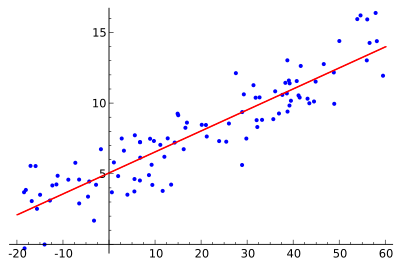

Linear models can be written in the general form from high school algebra: 

$y = mx + b$

in which $y$ represents some outcome variable (e.g., ice cream sales), $x$ represents some input variable (e.g., temperature), $m$ represents a transformation of that input, which is the _slope_ of the line. $b$ represents the intercept of that line. In practical terms, we would describe the slope of line ($m$) that says how much more (or less) ice cream is bought than average ($b$) depending on what temperature it is outside.

## Neural networks are just fancy linear models

$y$ in the above example is usually an outcome variable that we know. When we make linear models, we are doing **supervised learning**. That is, we have a known **outcome** ($y$) that we want to **predict** from some set of variables ($X$ to denote several $x$'s), so we need to learn slopes for every $x \in X$. 

Neural networks contain additional architecture that can make more sophisticated computations. Neural networks often have **hidden layers**, which allow us to capture complex relationships between an outcome ($y$) and the input ($X$). When we have a relationship that is not captured by a simple slope, we want to learn **nonlinear** $m$s. 

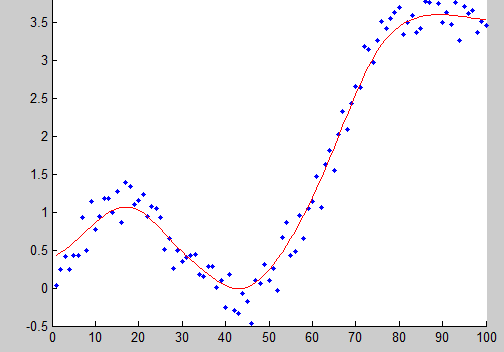

## `word2vec` uses a simple neural network architecture

`word2vec` is a three-layer neural network composed of two matrices stacked on top of each other. Like `LSA`, `word2vec` is basically matrix multiplication. When we obtained document embeddings from our trained PCA model for LSA, we multiplied the original bag-of-words representation with the projection matrix of word vector representations (`bow_abstracts * word_vectors`). We basically do the same for `word2vec`.

<img src="https://i.stack.imgur.com/sAvR9.png" width=700/>

Both of the matrices of CBOW can be thought of as "projection" matrices. The first one is of size $|V| \times k$ and the second one is of size $k \times |V|$. Like our PCA example, `word2vec` also does **dimensionality reduction** so $k$ corresponds to whatever size we want our **hidden units** to be. This is just like when we pick `n_components_` for PCA. Each element in the two matrices can be thought of as a **weight** so when we multiply a bag-of-words representation (dimensionality $1 \times |V|$) by the first of these matrices ($|V| \times k$) by we get a $k$-dimensional vector back (the $|V|$s cancel out).

The very first matrix (of size $|V| \times k$) is usually what people refer to when they mean the word embeddings that `word2vec` makes.



## Prediction for word2vec to train word embeddings

The input and the desired output of a `word2vec` model are both the bag-of-words representation. `word2vec2` learns from data, one vector at a time. At each step, a `word2vec` model will get a single bag-of-words representation and be asked to **predict**, just like a linear model. 

`word2vec` learns by **prediction error**. The job of CBOW is to predict a single held-out word from all of the surrounding words **in a sliding window**. Consider the sentence, "My cat Vector is very old.", which we can tokenize as `["My", "cat", "Vector", "is", "very", "old", "."]`.

| Input      | Desired output |
| ----------- | ----------- |
| My, cat, is, very, old, .      | Vector       |
| My, cat, Vector, very, old, .   | is        |
| ...   | ...        |
| My, cat, Vector, is, very, old   | .        |

Each word gets predicted by words that surround it. This is the **contextual** part of the `word2vec` model. `word2vec` learns that two words like "dog" and "cat" are similar when they typically have the same **context words** predicting them.


In [23]:
sentence = ["a", "b", "c", "d", "e"]

sliding_window = 2
for i, w in enumerate(sentence):
  left_context = sentence[i - sliding_window:i]
  right_context = sentence[i + 1 :i + sliding_window + 1]
  print(w, left_context, right_context)
  context = left_context + right_context

a [] ['b', 'c']
b [] ['c', 'd']
c ['a', 'b'] ['d', 'e']
d ['b', 'c'] ['e']
e ['c', 'd'] []


## Steps of word2vec (CBOW)

1. Determine how big the window should be
  * Three back, three forward?
  * A whole sentence?
  * Symmetrical or asymmetrical windows?
2. Transform the context into a bag-of-words representation by extracting those words in the window
3. Transform the target word into a bag-of-words representation (=exactly 1 dimension will have a 1, all else zeroes)
3. Give the bag-of-words representation to CBOW
  * Average the current word embeddings for the bag-of-words in the input
4. Multiply $k$-dimensional vector by projection matrix (of size $k \times |V|$)
5. Transform output using [**softmax** function](https://en.wikipedia.org/wiki/Softmax_function). Produces a vector of probabilities.
6. Compute the **error** between the output (a vector of probabilities) and the actual expectation (in 3)
7. **Backpropagate** the error. This adjusts the matrices to be better at prediction.

# Syntagmatic similarity

* Co-occur = Similar
* Cat, pet, chase
* Common from LSA

# Paradigmatic similarity

* Co-occur with the same things = Similar
* Dog, cat, mouse, hamsters
* Common from word2vec

Note: There are technically two `word2vec` models -- the "**Continuous Bag-of-Words**" (CBOW) model and "**skip-gram**." Skip-gram is significantly more complex than CBOW so we will not cover this here. But, there is a good discussion of it in the SLP3 book! I will refer to CBOW as `word2vec` here. Always be sure to check which algorithm the authors mean in any papers you read.

In [25]:
tokenized_abstracts = [word_tokenize(x) for x in abstracts]

In [26]:
help(Word2Vec)

Help on class Word2Vec in module gensim.models.word2vec:

class Word2Vec(gensim.models.base_any2vec.BaseWordEmbeddingsModel)
 |  Word2Vec(sentences=None, corpus_file=None, size=100, alpha=0.025, window=5, min_count=5, max_vocab_size=None, sample=0.001, seed=1, workers=3, min_alpha=0.0001, sg=0, hs=0, negative=5, ns_exponent=0.75, cbow_mean=1, hashfxn=<built-in function hash>, iter=5, null_word=0, trim_rule=None, sorted_vocab=1, batch_words=10000, compute_loss=False, callbacks=(), max_final_vocab=None)
 |  
 |  Train, use and evaluate neural networks described in https://code.google.com/p/word2vec/.
 |  
 |  Once you're finished training a model (=no more updates, only querying)
 |  store and use only the :class:`~gensim.models.keyedvectors.KeyedVectors` instance in `self.wv` to reduce memory.
 |  
 |  The model can be stored/loaded via its :meth:`~gensim.models.word2vec.Word2Vec.save` and
 |  :meth:`~gensim.models.word2vec.Word2Vec.load` methods.
 |  
 |  The trained word vectors can a

In [27]:
from gensim.models import Word2Vec

model = Word2Vec(sentences=tokenized_abstracts,
                 size=100, window=5, min_count=1, workers=4)

In [28]:
model.most_similar("annotation")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('annotations', 0.6894370317459106),
 ('2+1', 0.605654239654541),
 ('coding', 0.6048095226287842),
 ('construction', 0.5795214176177979),
 ('enrichment', 0.5551689267158508),
 ('annotating', 0.5536321401596069),
 ('creation', 0.5446563959121704),
 ('annotated', 0.5411858558654785),
 ('evaluation', 0.5304673314094543),
 ('analysis', 0.5106405019760132)]

In [29]:
model.most_similar("parsing")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('parsers', 0.6895569562911987),
 ('tagging', 0.6513684988021851),
 ('parser', 0.6427717208862305),
 ('labeling', 0.5811421275138855),
 ('trees', 0.5802563428878784),
 ('dependency', 0.5662418603897095),
 ('scaffolds', 0.546824038028717),
 ('SRL', 0.5444870591163635),
 ('table-column', 0.5389926433563232),
 ('heterogeneity/gap', 0.5268558859825134)]